In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('./ml-fairness-gym'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environments import infectious_disease as id
from experiments import infectious_disease as ide
from agents import infectious_disease_agents as ida

import networkx as nx
import numpy as np    

2022-02-13 13:10:38.668550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/evanlavender/miniconda3/envs/machine-learning/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-13 13:10:38.668582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Params(transition_matrix=array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]]), treatment_transition_matrix=array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]]), state_names=['susceptible', 'infected', 'recovered'], healthy_index=0, infectious_index=1, healthy_exit_index=1, infection_probability=0.75, population_graph=<networkx.classes.graph.Graph object at 0x7f0b0231a880>, initial_health_state=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], initial_health_state_seed=27, num_treatments=1, max_treatments=1, burn_in=0)


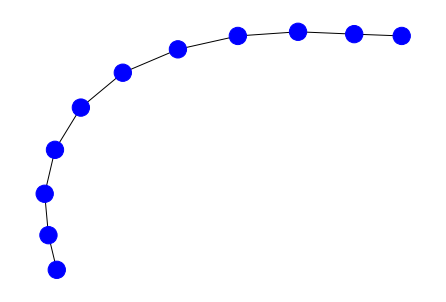

In [2]:
np.random.seed(13)

TAU   = 0.75
RHO   = 1.0
ide.GRAPHS["chain"] = nx.generators.path_graph(11)

EXP = ide.Experiment()
EXP.graph_name = "chain"
EXP.infection_probability     = TAU
EXP.infected_exit_probability = RHO
EXP.num_treatments = 1
EXP.burn_in = 0
# EXP.agent_constructor = ida.RandomAgent
EXP.agent_constructor = ide.NullAgent
EXP.scenario_builder()
print(EXP.env.initial_params)

positions = nx.spring_layout(EXP.env.initial_params.population_graph, seed=13)
color_map = ["blue", "red", "purple"]
EXP.env.render(color_map, pos=positions)

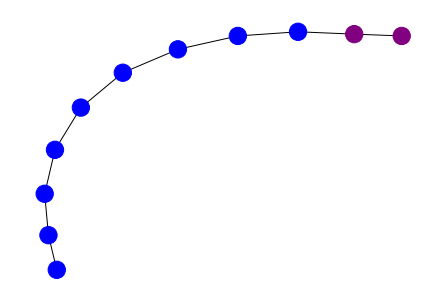

In [3]:
EXP.num_steps = 5
results = EXP.run()["metric_results"]
states = np.array(results["states"])
sick_days = np.array(results["sick-days"])

EXP.env.render(color_map, pos=positions)

In [10]:
def _num_sickdays(states):
    n = np.zeros(states.shape[1], dtype=int)
    for i in range(states.shape[1]):
        col = states[:, i]
        n[i] = np.count_nonzero(col == 1)
    return n

num_sickdays = _num_sickdays(states)
print("num_sickdays\n", num_sickdays)

total_sickdays = np.sum(num_sickdays)
print("total_sickdays", total_sickdays)

num_sickdays
 [1 1 0 0 0 0 0 0 0 0 0]
total_sickdays 2


In [61]:
from tqdm import trange

def process_metrics(i, metrics, results):
    states = np.array(results["states"])
    num_sickdays = _num_sickdays(states)
    # print("num_sickdays\n", num_sickdays)
    total_sickdays = np.sum(num_sickdays)
    # print("total_sickdays", total_sickdays)
    metrics["num_sickdays"] += num_sickdays

def run_simulations(n_sims, exp):
    size = ide.GRAPHS[exp.graph_name].number_of_nodes()
    metrics = {
        "num_sickdays": np.zeros(size)
    }

    exp.num_steps = 15
    for i in trange(n_sims):
        exp.seed = i
        r = exp.run()
        process_metrics(i, metrics, r["metric_results"])
    return metrics

N = 1000
metrics = run_simulations(N, EXP)

100%|██████████| 1000/1000 [00:46<00:00, 21.37it/s]


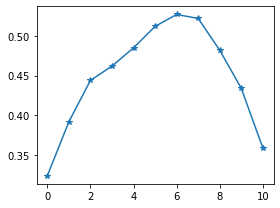

In [62]:
import matplotlib.pyplot as plt

num_sickdays = metrics["num_sickdays"]

plt.figure(figsize=(4, 3))
x = range(num_sickdays.shape[0])
y = num_sickdays / N
# plt.scatter(x, y)
plt.plot(x, y, "-*")
plt.tight_layout()
plt.show()